In [21]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [22]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph]


### Human in the Loop

사람이 참여하는 루프를 만들어 보겠습니다.  
  
`human_in_the_loop` 은 고유명사처럼 사용하는 문장입니다.   
  
특정 노드에서 인터럽트를 걸어서 사람이 개입을 해서 상태값 조회를 하거나 수정, 재개 할 수 있습니다.  
  
LangGraph의 가장 큰 장점 중에 하나가 `human_in_the_loop` 입니다.   
  
LangGraph는 여러 가지 방법으로 human-in-the-loop 워크플로를 지원합니다.

In [23]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from graphs import visualize_graph
from tools_news import GoogleNews


##### 1. 상태(State) 정의
class State(TypedDict):
    # 메모리 저장소 추가
    messages: Annotated[list, add_messages]


##### 2. 도구 정의 및 바인딩
# 도구 초기화
news_tool = GoogleNews()


@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


tools = [search_keyword]

# llm 초기화
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# llm과 도구 바인딩
llm_with_tools = llm.bind_tools(tools)


##### 3. 노드 추가
# 챗봇 함수 정의, 노드 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {
        "messages": llm_with_tools.invoke(state["messages"]),
    }


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

##### 4. 엣지 추가
# START > chatbot
graph_builder.add_edge(START, "chatbot")

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

##### 메모리 저장소 초기화
memory = MemorySaver()

`human_in_the_loop` 를 사용하기 위해서는 메모리 저장소가 필요합니다.  
  
메모리를 상용하여 intrrupt_before 를 추가합니다.

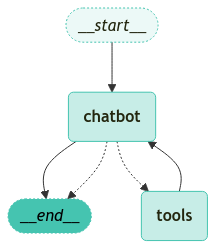

In [24]:
###### 6. interrupt_before 추가
# 그래프 빌더 컴파일
graph = graph_builder.compile(checkpointer=memory)

# 그래프 시각화
visualize_graph(graph)

메세지 출력을 합니다.

In [25]:
from langchain_print import pretty_print_messages
from langchain_core.runnables import RunnableConfig

# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
user_input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": "1"},
    tags=["my-rag"],
)

# 그래프 실행
for event in graph.stream(
    input=user_input,
    config=config,
    stream_mode="values",
    interrupt_before=["tools"],  # tools 노드 전에 inturrpt 실행
):
    for key, value in event.items():
        print(f"\n[ {key} ]\n")
        pretty_print_messages(value)


[ messages ]

================================ Human Message =================================

2024년 노벨 문학상 관련 뉴스를 알려주세요.

[ messages ]

================================ Human Message =================================

2024년 노벨 문학상 관련 뉴스를 알려주세요.
================================== Ai Message ==================================
Tool Calls:
  search_keyword (96f92bd6-7354-441f-a5f6-5d64b2aea01d)
 Call ID: 96f92bd6-7354-441f-a5f6-5d64b2aea01d
  Args:
    query: 2024년 노벨 문학상


그래프 상태를 확인하여 제대로 동작하였는지 확인합니다.

In [26]:
# 그래프 상태 스냅샷 설정
snapshot = graph.get_state(config)

# 다음 스냅샷 상태 확인, "다음노드 어디로 가야해?"
snapshot.next

('tools',)

메시지 트리를 확인해봅니다. 다음이 툴노드로 가는 것을 확인할 수 있습니다.

In [28]:
from langchain_print import display_message_tree

# 메시지 스냅샷에서 마지막 메시지 추출
exsisting_message = snapshot.values["messages"][-1]

# 메시지 트리 표시
display_message_tree(exsisting_message.tool_calls)

    index [0]
        name: "search_keyword"
        args:
            query: "2024년 노벨 문학상"
        id: "96f92bd6-7354-441f-a5f6-5d64b2aea01d"
        type: "tool_call"


다음으로는 이전에 종료된 지점 이후부터 이어서 그래프를 진행 하는 방법입니다.  
  
진행을 재개할때는 입력에 None 을 전달하면 됩니다.

In [29]:
# `None`은 현재 상태에 아무것도 추가 하지 않는 것을 의미
events = graph.stream(None, config=config, stream_mode="values")

for event in events:
    for key, value in event.items():
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search_keyword (96f92bd6-7354-441f-a5f6-5d64b2aea01d)
 Call ID: 96f92bd6-7354-441f-a5f6-5d64b2aea01d
  Args:
    query: 2024년 노벨 문학상
================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiVEFVX3lxTE9ncG5WS2Z6aUc4Sm03RWlDTGtYdmlHZG9WTVpMdTE3c240eVZ2d0tsZmdFa0t4NHhpYWRDellRV1Q2eVQ5ZDEtc0xfQUVaa2lrcUZDRg?oc=5", "content": "“문학은 생명 파괴에 맞서는 일” 한강, 세계를 울렸다 [2024 노벨문학상] - 매일경제"}, {"url": "https://news.google.com/rss/articles/CBMiggFBVV95cUxNWEF1akxLeHFsZ2pVT1VrT0xqNmdEUnBuUkxxazZkZ0JubVEwMjMxSkxkMUJpS0lyUWdhZlAtZlBxMWdBSkFMZWNmWVk3b1Q2Tzl6RHBiRE5kX09RS0V5WDZiSzJNMG82blM0cU9MXzYtbGJzYXBRZ0FuQ01MYkJkc2Rn?oc=5", "content": "한강, 노벨상 시상식 섰다…“글 속의 인물들 결코 잊힐 수 없어” - 한겨레"}, {"url": "https://news.google.com/rss/articles/CBMieEFVX3lxTFBQNGlRR1pyT3oyME81NzNlaE52SWpUbENhUWdiWjk3QVp4V2d0cm0xcFR6aTFudWVDTzVNcXRVZEJx

위에 메모리를 사용하였기때문에 각 단계별 상태값들이 스냅샷으로 메모리에 저장이 되어 있습니다.  
  
스냅샷으로 저장된 메모리안에 상태값들을 출력해보겠습니다.

In [31]:
to_replay = None

# 상태 기록 가져오기
for state in graph.get_state_history(config):
    print("메시지 수: ", len(state.values["messages"]), "다음 노드 : ", state.next)

    if len(state.values["messages"]) == 3:
        to_replay = state

메시지 수:  4 다음 노드 :  ()
메시지 수:  3 다음 노드 :  ('chatbot',)
메시지 수:  2 다음 노드 :  ('tools',)
메시지 수:  1 다음 노드 :  ('chatbot',)
메시지 수:  0 다음 노드 :  ('__start__',)


결과를 보면 그래프의 모든 단계에 대해 체크포인트가 저장되어 있습니다.  
  
환인하고자 하는 지점, 원하는 지점은 `to_replay` 변수에 저장되어 있습니다.  
  
이 방법을 활용하면 다시 시작하고자 하는 지점을 지정할 수 있습니다.

In [34]:
# 다음 항목의 다음 요소 출력
print(to_replay.next)

# 다음 항목의 설정 정보 출력
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efb8303-0ecb-6b98-8002-b041c6cabb0c'}}


`to_replay.config`에  `checkpoint_id`가 포함된 것을 확인할 수 있습니다.

In [35]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb8303-0ecb-6b98-8002-b041c6cabb0c'}}

`checkpoint_id`는 체크포인트의 고유 식별자입니다.  
  
아마 내부적으로는 체크포인트의 아이디를 참조하여 그 상태 값으로 돌아가 복원하는 듯 합니다.  
  
이 값을 사용하여 체크포인트를 다시 로드할 수 있습니다.  
- 단, 이때는 입력값을 None 으로 전달해야 합니다.

In [36]:
# `to_replay.config`는 `checkpoint_id`는 체크포인터에 저장된 상태에 해당
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiVEFVX3lxTE9ncG5WS2Z6aUc4Sm03RWlDTGtYdmlHZG9WTVpMdTE3c240eVZ2d0tsZmdFa0t4NHhpYWRDellRV1Q2eVQ5ZDEtc0xfQUVaa2lrcUZDRg?oc=5", "content": "“문학은 생명 파괴에 맞서는 일” 한강, 세계를 울렸다 [2024 노벨문학상] - 매일경제"}, {"url": "https://news.google.com/rss/articles/CBMiggFBVV95cUxNWEF1akxLeHFsZ2pVT1VrT0xqNmdEUnBuUkxxazZkZ0JubVEwMjMxSkxkMUJpS0lyUWdhZlAtZlBxMWdBSkFMZWNmWVk3b1Q2Tzl6RHBiRE5kX09RS0V5WDZiSzJNMG82blM0cU9MXzYtbGJzYXBRZ0FuQ01MYkJkc2Rn?oc=5", "content": "한강, 노벨상 시상식 섰다…“글 속의 인물들 결코 잊힐 수 없어” - 한겨레"}, {"url": "https://news.google.com/rss/articles/CBMieEFVX3lxTFBQNGlRR1pyT3oyME81NzNlaE52SWpUbENhUWdiWjk3QVp4V2d0cm0xcFR6aTFudWVDTzVNcXRVZEJxMGF2am51NmY1TjFtZUJVcDF4MVdEenpRNmFXbEVsT015NmRkWk1DVDhEY1k1Q1JqUnFCdTdLYQ?oc=5", "content": "50년간 봉인되는 노벨문학상의 비밀…한강, 대한민국의 새 역사를 쓰다 [스프] - 네이트 뉴스"}, {"url": "https://news.google.com/rss/articles/CBMi6AFBVV95cUxPOTJDcW15YnVXQ1Bm

#### 정리.

1. `MemorySaver를` 통해 그래프 실행 중의 모든 상태(state)가 체크포인트로 저장됩니다.
2. 각 체크포인트는 고유한 `checkpoint_id를` 가지고 있으며, 이는 `to_replay.config` 안에 저장됩니다:

    ```python
    {
        'configurable': {
            'thread_id': '1',
            'checkpoint_ns': '',
            'checkpoint_id': '1efb8303-0ecb-6b98-8002-b041c6cabb0c'
        }
    }
    ```

3. 특정 상태로 돌아가고 싶을 때:

    ```python
    # config에 있는 checkpoint_id를 사용해 해당 상태부터 실행
    graph.stream(None, to_replay.config, stream_mode="values")
    ```

- 입력값으로 `None`을 주는 것은 기존 상태를 그대로 사용하겠다는 의미입니다
- `to_replay.config`를 전달하면 LangGraph는 내부적으로 이 config에 있는 `checkpoint_id`를 참조하여 해당 시점의 상태를 복원하고 거기서부터 실행을 재개합니다


이런 방식으로 human-in-the-loop 시스템에서 특정 시점으로 돌아가거나, 중단된 지점에서 다시 시작하는 것이 가능해집니다.